In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import pandas_datareader as web

In [2]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

### load data

In [3]:
import yfinance as yf

company = 'META'
start = dt.datetime(2012,1,1)
end = dt.datetime(2020,1,1)
data = yf.download(company, start = start,  end = end)


print(data)

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            META        META        META        META       META
Date                                                                 
2012-05-18   38.084522   44.828761   37.855398   41.889986  573576400
2012-05-21   33.900505   36.520498   32.874426   36.390992  168192700
2012-05-22   30.882032   33.462177   30.822261   32.485906  101786600
2012-05-23   31.878227   32.376325   31.240663   31.250625   73600000
2012-05-24   32.904305   33.083620   31.649101   32.824611   50237200
...                ...         ...         ...         ...        ...
2019-12-24  204.339417  206.003060  204.219878  205.514934    6046300
2019-12-26  206.999268  207.029167  204.528709  204.787730    9350700
2019-12-27  207.308105  208.134934  205.803842  207.875928   10284200
2019-12-30  203.632141  207.108851  203.124072  207.069009   10524300
2019-12-31  204.468948  204.777766  202.825233  203.223705    8953500

[1917 rows x 5 colu

### prepare trainig data 

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [9]:
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### build the model

In [11]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))#prediction of the next closing price

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - loss: 0.0775
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0043
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0037
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0037
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0033
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0035
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0031
Epoch 8/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0033
Epoch 9/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0028
Epoch 10/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0030
Epoch 11/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0037
Epoch 12/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0026
Epoch 13/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0024
Epoch 14/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0026
Epoch 15/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0024
Epo

### testing the model accuracy on existing data


In [13]:
#prepare test data
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = yf.download(company, start=test_start, end=test_end)

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

[*********************100%***********************]  1 of 1 completed


In [15]:
model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

### make predictions on test data

In [17]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


### plot test predictions

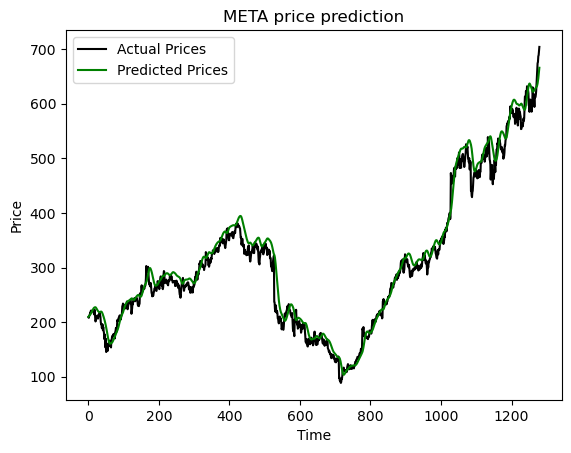

In [19]:
plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title(f'{company} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

### predict next day

In [21]:
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days : len(model_inputs) + 1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
[[673.03845]]
